# Evaluate Classifier Predictions

**Gregory Way, 2018**

In the following notebook I evaluate the predictions made by the Ras, _NF1_, and _TP53_ classifiers in the input PDX RNAseq data.

## Procedure

1. Load status matrices
  * These files store the mutation status for _TP53_ and Ras pathway genes for the input samples
2. Align barcode identifiers
  * The identifiers matching the RNAseq data to the status matrix are not aligned.
  * I use an intermediate dictionary to map common identifiers
3. Load predictions (see `1.apply-classifier.ipynb` for more details)
4. Evaluate predictions
  * I visualize the distribution of predictions between wild-type and mutant samples for both classifiers

## Output

The output of this notebook are several evaluation figures demonstrating the predictive performance on the input data for the three classifiers. Included in this output are predictions stratified by histology.

In [1]:
import os
import random
from decimal import Decimal
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt

from utils import get_mutant_boxplot, perform_ttest

In [2]:
%matplotlib inline

## Load Status Matrix

In [3]:
file = os.path.join('data', 'raw', '2018-09-21-muts-fusions.txt')
status_df = pd.read_table(file)

print(status_df.shape)
status_df.head(3)

(168, 15)


,Model,Histology.Detailed,Chromosome,Start_position,End_position,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Hugo_Symbol,Variant_Classification,cDNA_Change,Protein_Change,VAF,dbNSFP_SIFT_pred,Confidence
0,ALL-03,MLL-ALL,2,30143477.0,30143477.0,C,C,T,ALK,Missense_Mutation,c.49G>A,p.A17T,0.470588,.,low
1,COG-N-415x,Neuroblastoma,2,29443695.0,29443695.0,G,G,T,ALK,Missense_Mutation,c.3522C>A,p.F1174L,0.484848,.,high
2,COG-N-452x,Neuroblastoma,2,29443695.0,29443695.0,G,G,T,ALK,Missense_Mutation,c.3522C>A,p.F1174L,0.478261,.,high


In [4]:
status_df.Confidence.value_counts()

high       117
unknown     26
low         25
Name: Confidence, dtype: int64

In [5]:
status_df.Hugo_Symbol.value_counts()

TP53      76
ALK       18
KRAS      16
NF1       12
DMD       10
NRAS      10
CIC        8
SOS1       7
PTPN11     4
HRAS       4
BRAF       3
Name: Hugo_Symbol, dtype: int64

In [6]:
status_df.Variant_Classification.value_counts()

Missense_Mutation    112
Shallow_Del           17
Fusion                13
Nonsense_Mutation     13
Frame_Shift_Del        5
Splice_Site            3
Frame_Shift_Ins        3
Deep_Del               1
In_Frame_Del           1
Name: Variant_Classification, dtype: int64

In [7]:
status_df['Histology.Detailed'].value_counts()

Osteosarcoma                  45
Neuroblastoma                 26
BCP-ALL                       26
Glioblastoma                  13
Ewing Sarcoma                 12
Ph-likeALL                     7
Embryonal Rhabdomyosarcoma     6
T-ALL                          4
Wilms                          4
Alveolar Rhabdomyosarcoma      4
MLL-ALL                        4
Medulloblastoma                4
Astrocytoma                    3
ATRT                           3
ETP-ALL                        2
Other Sarcoma                  2
Rhabdoid                       1
Small Cell Carcinoma           1
Colon Carcinoma                1
Name: Histology.Detailed, dtype: int64

In [8]:
pd.crosstab(status_df['Histology.Detailed'], status_df.Hugo_Symbol)

Hugo_Symbol,ALK,BRAF,CIC,DMD,HRAS,KRAS,NF1,NRAS,PTPN11,SOS1,TP53
Histology.Detailed,,,,,,,,,,,
ATRT,1,0,0,1,0,0,0,0,0,1,0
Alveolar Rhabdomyosarcoma,1,0,0,0,0,0,0,0,0,0,3
Astrocytoma,0,1,0,1,0,0,0,0,0,0,1
BCP-ALL,0,0,1,2,1,10,1,6,0,1,4
Colon Carcinoma,0,0,0,0,0,0,1,0,0,0,0
ETP-ALL,0,0,0,0,0,0,0,0,1,1,0
Embryonal Rhabdomyosarcoma,0,0,1,0,1,0,1,1,0,0,2
Ewing Sarcoma,0,0,1,3,1,0,0,0,0,0,7
Glioblastoma,0,0,3,1,1,0,3,0,0,3,2


In [9]:
# Obtain a binary status matrix
full_status_df = pd.crosstab(status_df['Model'], status_df.Hugo_Symbol)
full_status_df[full_status_df > 1] = 1
full_status_df = full_status_df.reset_index()

In [10]:
histology_df = status_df.loc[:, ['Model', 'Histology.Detailed']]
histology_df.columns = ['Model', 'Histology_Full']

full_status_df = (
    full_status_df
    .merge(histology_df, how='left', on="Model")
    .drop_duplicates()
    .reset_index(drop=True)
)

full_status_df.head()

,Model,ALK,BRAF,CIC,DMD,HRAS,KRAS,NF1,NRAS,PTPN11,SOS1,TP53,Histology_Full
0,ALL-03,1,0,0,0,0,0,0,0,0,0,0,MLL-ALL
1,ALL-07,0,0,0,0,0,1,0,0,0,0,0,BCP-ALL
2,ALL-08,0,0,0,1,0,0,0,0,0,0,0,T-ALL
3,ALL-108,0,0,0,0,0,1,0,0,0,0,0,Ph-likeALL
4,ALL-115,0,0,0,0,0,0,0,0,0,0,1,BCP-ALL


## Extract Gene Status

In [11]:
# Ras Pathway Alterations
ras_genes = ['ALK', 'NF1', 'PTPN11', 'BRAF', 'CIC', 'KRAS', 'HRAS', 'NRAS']

full_status_df = (
    full_status_df
    .assign(ras_status = full_status_df.loc[:, ras_genes]
            .max(axis='columns'))
)

## Load Clinical Data Information

This stores histology information

In [12]:
file = os.path.join('data', 'raw', '2018-05-22-pdx-clinical.txt')
clinical_df = pd.read_table(file)

# Make every histology with the word `Other` in it in the same class
clinical_df.loc[clinical_df.Histology.str.contains('Other'), 'Histology'] = "Other"

print(clinical_df.shape)
clinical_df.head(3)

(370, 7)


,Part of PPTC,Tumor_Sample_Barcode,Model,Diagnosis,Histology,Sex,Sample Phase of Therapy
0,yes,COG-N-589x-D1-human,COG-N-589x,Neuroblastoma,Neuroblastoma,Female,Diagnosis
1,yes,PPTC-COG-N-590x-D-human,COG-N-590x,Neuroblastoma,Neuroblastoma,Male,Diagnosis
2,yes,PPTC-COG-N-603x-D-human,COG-N-603x,Neuroblastoma,Neuroblastoma,Male,Diagnosis


In [13]:
clinical_df.Histology.value_counts()

ALL                 97
Osteosarcoma        60
Neuroblastoma       45
Medulloblastoma     29
Glioblastoma        22
Rhabdomyosarcoma    20
ATRT                18
Ewing Sarcoma       16
Other               15
Wilms               14
Ependymoma          13
PNET                 9
Astrocytoma          4
DIPG                 4
AML                  2
CNS germinoma        2
Name: Histology, dtype: int64

## Load Predictions and Merge with Clinical and Alteration Data

In [14]:
file = os.path.join('results', 'classifier_scores.tsv')
scores_df = pd.read_table(file)

scores_df = (
    scores_df.merge(
        clinical_df,
        how='left', left_on='sample_id', right_on='Model'
    )
    .merge(
        full_status_df,
        how='left', left_on='sample_id', right_on='Model'
    )
)

print(scores_df.shape)
scores_df.head()

(252, 28)


,sample_id,ras_score,tp53_score,nf1_score,ras_shuffle,tp53_shuffle,nf1_shuffle,Part of PPTC,Tumor_Sample_Barcode,Model_x,...,DMD,HRAS,KRAS,NF1,NRAS,PTPN11,SOS1,TP53,Histology_Full,ras_status
0,ALL-102,0.516375,0.447161,0.512023,0.473015,0.628489,0.477897,yes,PPTC-AF02-XTP1-B-1-0-D-human,ALL-102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALL-105,0.406924,0.537289,0.452825,0.424123,0.324875,0.546235,yes,PPTC-AF03-XTP1-A-1-0-D-human,ALL-105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALL-106,0.437307,0.380876,0.419952,0.397130,0.500320,0.479159,yes,PPTC-AF04-XTP1-A-1-0-D-human,ALL-106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALL-107,0.370617,0.444103,0.458372,0.490617,0.661135,0.502846,yes,PPTC-AF05-XTP1-B-1-0-D-human,ALL-107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALL-108,0.435229,0.460351,0.455453,0.472857,0.673772,0.399693,yes,PPTC-AF06-XTP1-A-1-0-D-human,ALL-108,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Ph-likeALL,1.0


In [15]:
scores_df = scores_df.assign(tp53_status = scores_df['TP53'])
scores_df = scores_df.assign(nf1_status = scores_df['NF1'])

In [16]:
gene_status = ['tp53_status', 'ras_status', 'nf1_status']
scores_df.loc[:, gene_status] = (
    scores_df.loc[:, gene_status].fillna(0)
)

scores_df.loc[scores_df['tp53_status'] != 0, 'tp53_status'] = 1
scores_df.loc[scores_df['ras_status'] != 0, 'ras_status'] = 1
scores_df.loc[scores_df['nf1_status'] != 0, 'nf1_status'] = 1

scores_df['tp53_status'] = scores_df['tp53_status'].astype(int)
scores_df['ras_status'] = scores_df['ras_status'].astype(int)
scores_df['nf1_status'] = scores_df['nf1_status'].astype(int)
              
scores_df.head(2)

,sample_id,ras_score,tp53_score,nf1_score,ras_shuffle,tp53_shuffle,nf1_shuffle,Part of PPTC,Tumor_Sample_Barcode,Model_x,...,KRAS,NF1,NRAS,PTPN11,SOS1,TP53,Histology_Full,ras_status,tp53_status,nf1_status
0,ALL-102,0.516375,0.447161,0.512023,0.473015,0.628489,0.477897,yes,PPTC-AF02-XTP1-B-1-0-D-human,ALL-102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,ALL-105,0.406924,0.537289,0.452825,0.424123,0.324875,0.546235,yes,PPTC-AF03-XTP1-A-1-0-D-human,ALL-105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


## Load Histology Color Codes

In [17]:
file = os.path.join('data', '2018-08-23-all-hist-colors.txt')
color_code_df = pd.read_table(file)
color_code_df.head(2)

color_dict = dict(zip(color_code_df.Histology, color_code_df.Color))
color_dict

{'ATRT': '#000000',
 'Alveolar Rhabdomyosarcoma': '#E8C51D',
 'Astrocytoma': '#ED2891',
 'BCP-ALL': '#97D1A9',
 'CNS Germinona': '#00A99D',
 'Colon Carcinoma': '#F89420',
 'DIPG': '#D3C3E0',
 'ETP-ALL': '#754C29',
 'Embryonal Rhabdomyosarcoma': '#00AEEF',
 'Ependymoma': '#C1A72F',
 'Ewing Sarcoma': '#542C88',
 'Glioblastoma': '#B2509E',
 'MLL-ALL': '#009444',
 'Medulloblastoma': '#D49DC7',
 'Neuroblastoma': '#EA7075',
 'Osteosarcoma': '#6E7BA2',
 'Other Renal': '#9EDDF9',
 'Other Sarcoma': '#F6B667',
 'PNET': '#F9ED32',
 'Ph+-ALL': '#3953A4',
 'Ph-likeALL': '#BE1E2D',
 'Rhabdoid': '#104A7F',
 'Small Cell Carcinoma': '#D97D25',
 'T-ALL': '#CEAC8F',
 'Wilms': '#007EB5'}

## Perform ROC and Precision-Recall Analysis using all Alteration Information

In [18]:
n_classes = 3

fpr_pdx = {}
tpr_pdx = {}
precision_pdx = {}
recall_pdx = {}
auroc_pdx = {}
aupr_pdx = {}

fpr_shuff = {}
tpr_shuff = {}
precision_shuff = {}
recall_shuff = {}
auroc_shuff = {}
aupr_shuff = {}

idx = 0
for status, score, shuff in zip(('ras_status', 'nf1_status', 'tp53_status'),
                                ('ras_score', 'nf1_score', 'tp53_score'),
                                ('ras_shuffle', 'nf1_shuffle', 'tp53_shuffle')):
    
    # Obtain Metrics
    sample_status = scores_df.loc[:, status]
    sample_score = scores_df.loc[:, score]
    shuffle_score = scores_df.loc[:, shuff]
 
    # Get Metrics
    fpr_pdx[idx], tpr_pdx[idx], _ = roc_curve(sample_status, sample_score)
    precision_pdx[idx], recall_pdx[idx], _ = precision_recall_curve(sample_status, sample_score)
    auroc_pdx[idx] = roc_auc_score(sample_status, sample_score)
    aupr_pdx[idx] = average_precision_score(sample_status, sample_score)
    
    # Obtain Shuffled Metrics
    fpr_shuff[idx], tpr_shuff[idx], _ = roc_curve(sample_status, shuffle_score)
    precision_shuff[idx], recall_shuff[idx], _ = precision_recall_curve(sample_status, shuffle_score)
    auroc_shuff[idx] = roc_auc_score(sample_status, shuffle_score)
    aupr_shuff[idx] = average_precision_score(sample_status, shuffle_score)
    
    idx += 1

In [19]:
if not os.path.exists('figures'):
    os.makedirs('figures')

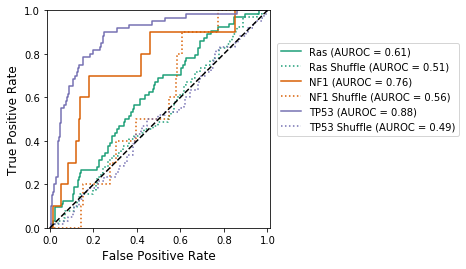

In [20]:
# Visualize ROC curves
plt.subplots(figsize=(4, 4))

labels = ['Ras', 'NF1', 'TP53']
colors = ['#1b9e77', '#d95f02', '#7570b3']

for i in range(n_classes):
    plt.plot(fpr_pdx[i], tpr_pdx[i],
             label='{} (AUROC = {})'.format(labels[i], round(auroc_pdx[i], 2)),
             linestyle='solid',
             color=colors[i])

    # Shuffled Data
    plt.plot(fpr_shuff[i], tpr_shuff[i],
             label='{} Shuffle (AUROC = {})'.format(labels[i], round(auroc_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'classifier_roc_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

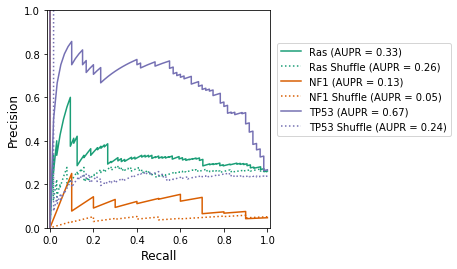

In [21]:
# Visualize PR curves
plt.subplots(figsize=(4, 4))

for i in range(n_classes):
    plt.plot(recall_pdx[i], precision_pdx[i],
             label='{} (AUPR = {})'.format(labels[i], round(aupr_pdx[i], 2)),
             linestyle='solid',
             color=colors[i])
    
    # Shuffled Data
    plt.plot(recall_shuff[i], precision_shuff[i],
             label='{} Shuffle (AUPR = {})'.format(labels[i], round(aupr_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'classifier_precision_recall_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

## Perform t-test against status classification

In [22]:
t_results_ras = perform_ttest(scores_df, gene='ras')
t_results_ras

Ttest_indResult(statistic=2.7606694576486674, pvalue=0.006737983225648076)

In [23]:
t_results_nf1 = perform_ttest(scores_df, gene='nf1')
t_results_nf1

Ttest_indResult(statistic=2.405641350136646, pvalue=0.037906182501522605)

In [24]:
t_results_tp53 = perform_ttest(scores_df, gene='tp53')
t_results_tp53

Ttest_indResult(statistic=12.032297477049068, pvalue=2.864524985978452e-22)

## Observe broad differences across sample categories

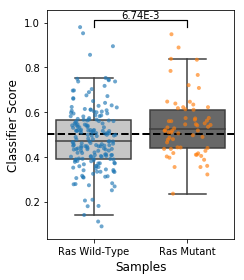

In [25]:
# Ras
get_mutant_boxplot(df=scores_df,
                   gene="Ras",
                   t_test_results=t_results_ras)

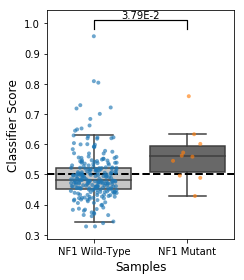

In [26]:
# NF1
get_mutant_boxplot(df=scores_df,
                   gene="NF1",
                   t_test_results=t_results_nf1)

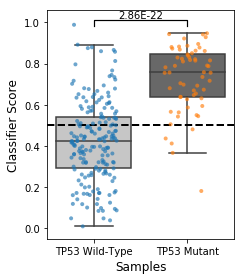

In [27]:
# TP53
get_mutant_boxplot(df=scores_df,
                   gene="TP53",
                   t_test_results=t_results_tp53)

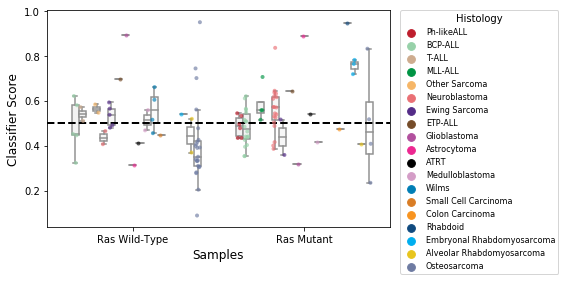

In [28]:
# Ras Alterations
get_mutant_boxplot(df=scores_df,
                   gene='Ras',
                   histology=True,
                   hist_color_dict=color_dict)

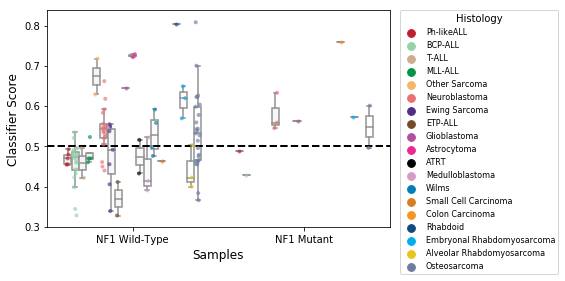

In [29]:
# NF1 Alterations
get_mutant_boxplot(df=scores_df,
                   gene='NF1',
                   histology=True,
                   hist_color_dict=color_dict)

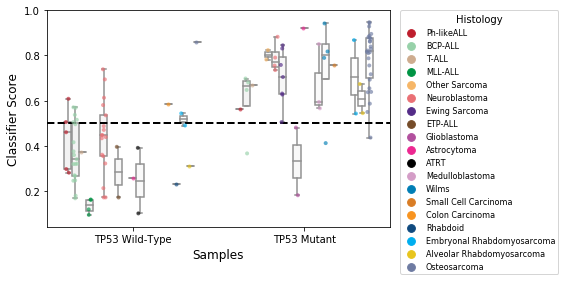

In [30]:
# TP53 Alterations
get_mutant_boxplot(df=scores_df,
                   gene='TP53',
                   histology=True,
                   hist_color_dict=color_dict)